In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib as mpl

import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
def truncate_normal(input: torch.Tensor, radius):
    in_norm = input.norm(dim=1, keepdim=True)
    in_norm[in_norm > radius] = radius
    return input * in_norm / input.norm(dim=1, keepdim=True)


class PolyTailLoss(torch.nn.Module):
    def __init__(self, alpha):
        self.alpha = alpha
        super(PolyTailLoss, self).__init__()

    def forward(self, logits, target):
        return self.margin_fn(logits * target)

    def margin_fn(self, margin_vals):
        indicator = margin_vals <= 1
        inv_part = torch.pow(margin_vals, -1 * self.alpha)
        logit_inner = -1 * margin_vals
        logit_part = (torch.log(torch.exp(logit_inner) + 1)) / math.log(
            1 + math.exp(-1)
        )
        scores = logit_part * indicator + inv_part * (~indicator)
        return scores

Epoch 0: loss=0.00023569776385556906
Epoch 5: loss=0.00020224493346177042
Epoch 10: loss=0.0003787946770898998
Epoch 15: loss=0.0001707637420622632
Epoch 20: loss=0.00010676702368073165
Epoch 25: loss=0.00012397333921398968
Epoch 30: loss=5.20594185218215e-05
Epoch 35: loss=0.0001519116194685921
Epoch 40: loss=3.698902582982555e-05
Epoch 45: loss=4.4191983761265874e-05
Epoch 50: loss=4.3995678424835205e-05
Epoch 55: loss=8.791631262283772e-05
Epoch 60: loss=6.707328429911286e-05
Epoch 65: loss=3.050333725695964e-05
Epoch 70: loss=4.206973244436085e-05
Epoch 75: loss=9.21583196031861e-05
Epoch 80: loss=9.473826503381133e-05
Epoch 85: loss=3.126778028672561e-05
Epoch 90: loss=3.7437028368003666e-05
Epoch 95: loss=6.224548269528896e-05
[]
Epoch 0: loss=0.0003522212791722268
Epoch 5: loss=0.00027513111126609147
Epoch 10: loss=0.00047479261411353946
Epoch 15: loss=0.00025785365141928196
Epoch 20: loss=0.00013445908552967012
Epoch 25: loss=0.00011701579205691814
Epoch 30: loss=5.594509639195

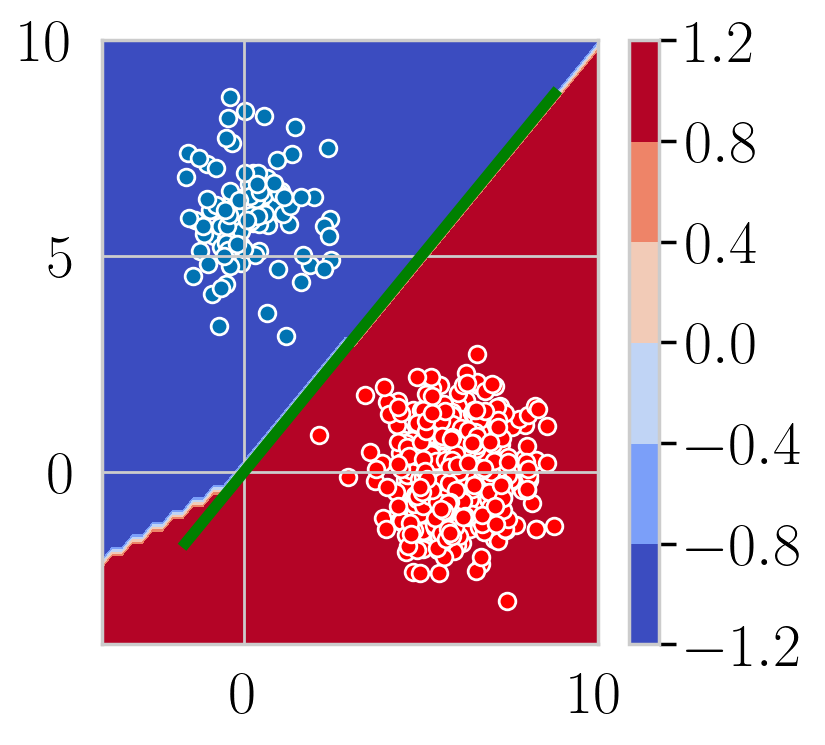

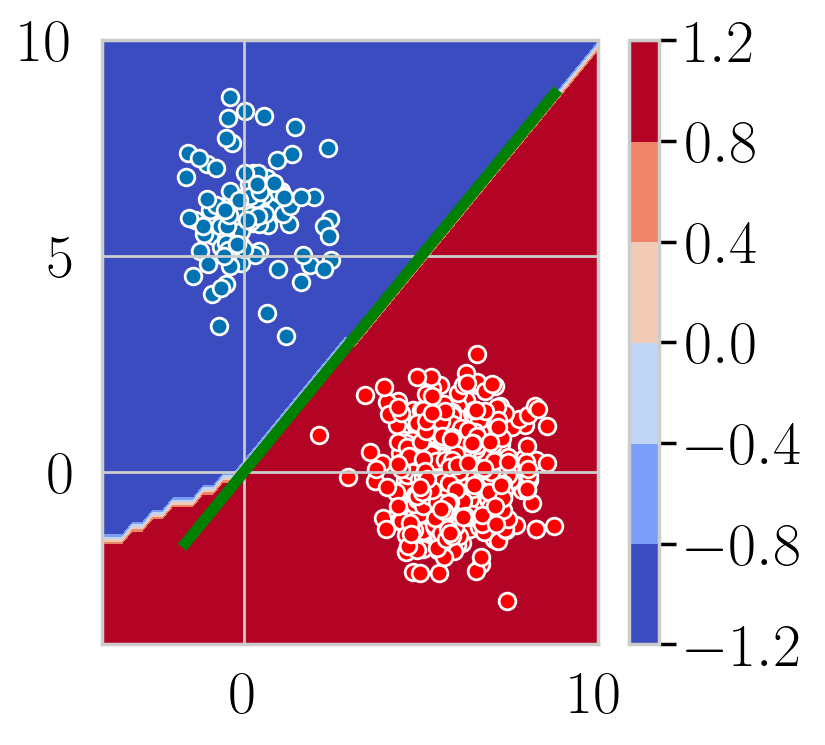

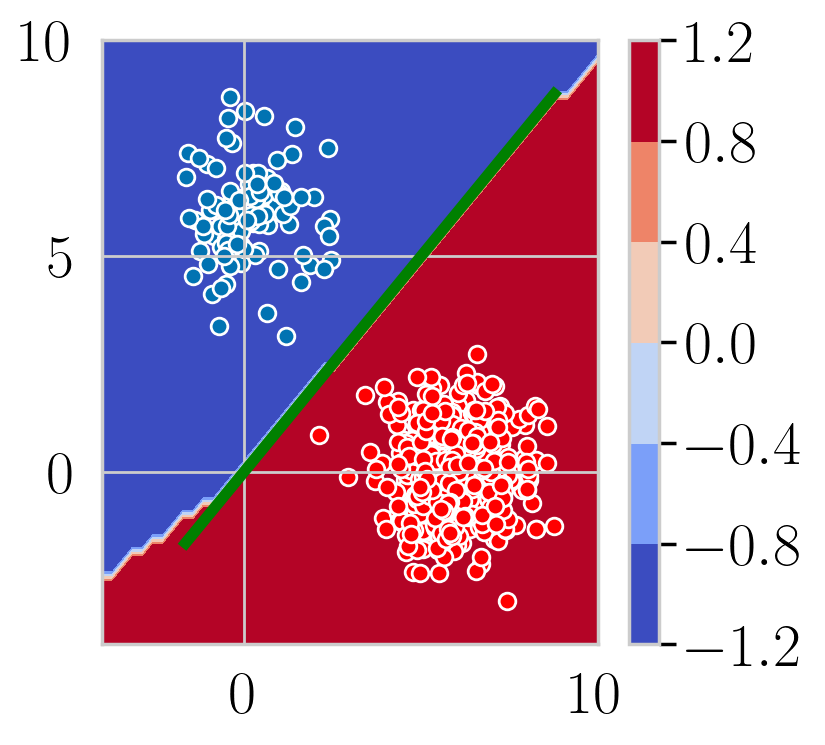

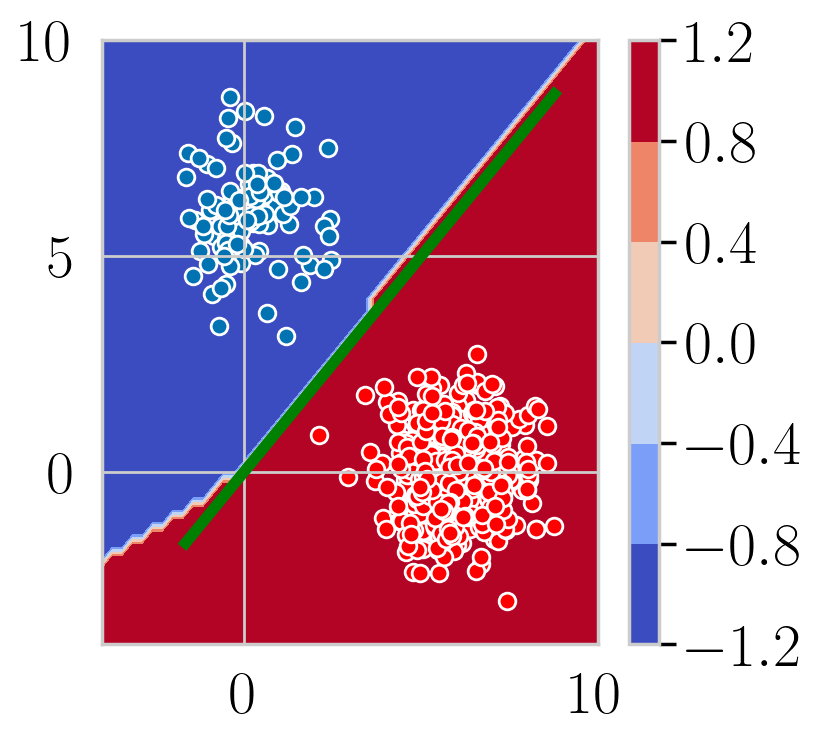

In [14]:
from itertools import product

for loss_type, weight_type in product(["poly", "logit"], ["iw", "none"]):

    torch.random.manual_seed(3)

    class_one_num = 100
    class_two_num = 500
    alpha = 5.0
    num_epochs = 100
    batch_size = 32
    lr = 0.1
    device = "cuda"


    class_one = truncate_normal(torch.randn(class_one_num, 2), 6) + torch.tensor([[0, 6]])
    class_two = truncate_normal(torch.randn(class_two_num, 2), 6) + torch.tensor([[6, 0]])

    x_seq = torch.cat((class_one, class_two), dim=0)
    y_seq = torch.cat(
        (torch.ones(class_one.shape[0]) * (-1), torch.ones(class_two.shape[0]))
    )

    dataset = torch.utils.data.TensorDataset(x_seq, y_seq)
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=True
    )

    #model = torch.nn.Linear(2, 1)
    model = torch.nn.Sequential(torch.nn.Linear(2, 100), torch.nn.ReLU(), torch.nn.Linear(100, 100), torch.nn.ReLU(), torch.nn.Linear(100, 1))
    
    model = model.to(device)

    if loss_type == "logit":
        logit_loss = torch.nn.SoftMarginLoss(reduction="none")
    else:
        logit_loss = PolyTailLoss(alpha=alpha)

    optimizer = optim.SGD(model.parameters(), lr=0.1)

    w_seq = []
    for i in range(num_epochs):
        for xs, ys in dataloader:
            xs = xs.to(device)
            ys = ys.to(device)

            optimizer.zero_grad()

            margin = model(xs).squeeze()
            if weight_type == "iw":
                loss_ratio = (ys > 0) + (ys < 0) * class_two_num / float(class_one_num)
            else:
                loss_ratio = torch.ones(ys.shape[0])
            loss_ratio = loss_ratio.to(device)
            loss = torch.mean(logit_loss(margin, ys) * loss_ratio)

            loss.backward()

            optimizer.step()
        if i % 5 == 0:
            print(f"Epoch {i}: loss={loss.item()}")
            #w_seq.append(
            #    [(n, p.detach().cpu().numpy().copy()) for n, p in model.named_parameters()]
            #)

    print(w_seq)

    model = model.cpu()

    xrng = np.linspace(min(x_seq[:, 0]), max(x_seq[:, 0]), num=50)


    def ymap(xseq, weight, bias):
        print(weight)
        print(bias)
        return (xseq * weight[0] + bias) / (-1 * weight[1])


    fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
    xlim = ylim = (-4, 10)
    ax.set(ylim=ylim, xlim=xlim)
    
    g1 = np.linspace(*xlim)
    g2 = np.linspace(*ylim)
    
    x1, x2 = np.meshgrid(g1, g2)
    X = np.stack([x1, x2], axis=-1).reshape(-1, 2)

    y = model(torch.as_tensor(X).float()).detach().cpu().numpy()
    y = 2 * (y > 0) - 1.
    y_grid = y.reshape(len(g1), len(g2))
    
    lim = max(abs(np.min(y)), abs(np.max(y)))

    #fig, ax = plt.subplots()
    cs = ax.contourf(x1, x2, y_grid, cmap="coolwarm", vmin=-lim, vmax=lim, levels=5)
    cb = fig.colorbar(cs, ax=ax)

    
    ax.scatter(class_one[:, 0], class_one[:, 1], edgecolors="w")
    ax.scatter(class_two[:, 0], class_two[:, 1], color="red", edgecolors="w")
#    cmap = plt.cm.get_cmap("winter")
#     for widx in range(len(w_seq)):
#         frac_val = float(widx) / float(len(w_seq))
#         print(frac_val)
#         yvals = ymap(xrng, w_seq[widx][0][1][0], w_seq[widx][1][1])
#         ax.plot(xrng, yvals, color=cmap(frac_val))
    ax.plot(xrng, xrng, color="green", linewidth=4)
    
    fig.savefig(
        ""
        + loss_type
        + "-"
        + weight_type
        + "-"
        + str(class_one_num)
        + "-"
        + str(class_two_num)
        + ".pdf"
    )